## Assignment 5: Machine learning

In this assignment, we'll practice the classification skills from machine learning. We'll use the precinct-level voting data to predict support for Prop 21 (rent control) on the 2020 ballot.

(1) Start by loading the 2020 elections results from LA County into a `pandas` dataframe, `voteDf` (This is exactly the same data as we used in class; I put another copy of the data file in the assignment GitHub folder to make things easier.)

In [4]:
import pandas as pd

voteDf = 999 # replace with your dataframe

### BEGIN SOLUTION
fn = 'c037_g20_sov_data_by_g20_srprec.csv'
voteDf = pd.read_csv(fn)
### END SOLUTION
print(len(voteDf))
print(voteDf.head())

4313
   county    srprec  addist  cddist  sddist  bedist  TOTREG  DEMREG  REPREG  \
0      19  0050005A      36      25      21       1    1974       0       0   
1      19  0050014A      36      25      21       1     697       0       0   
2      19  0050022A      36      27      25       1      61       0       0   
3      19  0050024A      41      27      25       1       0       0       0   
4      19  0050025A      36      25      25       1       5       0       0   

   AIPREG  ...  PR_23_Y  PR_24_N  PR_24_Y  PR_25_N  PR_25_Y  SENAIP01  \
0       0  ...      430      945      771     1304      398         0   
1       0  ...      100      314      223      427      116         0   
2       0  ...       10       27       22       35       15         0   
3       0  ...        0        0        0        0        0         0   
4       0  ...        1        2        3        1        3         0   

   SENDEM01  SENDEM02  SENLIB01  SENREP01  
0       524         0         0      

In [5]:
# Autograding tests - do not edit
assert len(voteDf) == 4313
assert isinstance(voteDf, pd.DataFrame)

(2) To do some prediction, we'll want to add variables from (say) the census or other sources.
For that, we need the lookup file that matches precincts to census blocks and tracts. [You can find it here](https://statewidedatabase.org/d10/g20_geo_conv.html), or just use the file `c037_g20_sr_blk_map.csv` in your GitHub repository. (Note that there are several types of precincts; the ones that we are using here are called `srprec`. 

Create a new dataframe, `voteDf2`, that has the vote counts (for all of the propositions and other races) aggregated to census tract.

*Hints:* This is a multi-stage process. Note that each precinct covers many census blocks. The `pctsrprec` column tells you how much of the precinct lies within that block. For example, in the first few rows of `c037_g20_sr_blk_map.csv`, you'll see 49 different rows for precint `0050003A`, each matching to a different census block, with the `pctsrprec` column adding up to 100.

So my suggestions are to:
- load in the lookup data into a new dataframe, `lookupdf`
- join the voting dataframe to the lookup dataframe using `srprec`, to create a new dataframe called `tmpjoin`. This is a 1:many join, since there are many census blocks per precinct. I suggest doing an inner join, as the Null values are not going to be useful to us.
- calculate the number of votes per census block, by multiplying each column of your voting data file by `pctsrprec` and dividing by 100. (You could do this in a `for` loop.) In other words, allocate the votes in a given precinct across the census blocks.
- add up the number of votes per census tract, using a `groupby`. (Note that you can do groupby with lots of different columns. E.g., `tmpjoin.groupby('tract')[['col1','col2','col3']].sum()` will give you the tract-level sums for columns called `col1`, `col2`, and `col3`, for example.)

In [6]:
fn2 = 'c037_g20_sr_blk_map.csv'

voteDf2 = 999 # your code here

### BEGIN SOLUTION
lookupdf = pd.read_csv(fn2)

# left join to our voting data
tmpjoin = voteDf.set_index('srprec').join(lookupdf.set_index('srprec'), how='inner')

# get list of columns from the original dataframe, excluding the ones that aren't about voting
cols = [col for col in voteDf.columns if col not in ['county','srprec','addist', 'cddist','sddist','bedist']]

# number of votes per block
for col in cols:
    tmpjoin[col] = tmpjoin[col] * tmpjoin.pctsrprec / 100

# aggregate to census tract
voteDf2 = tmpjoin.groupby('tract')[cols].sum()

### END SOLUTION
voteDf2.head()
print(voteDf2.TOTVOTE.sum())
print(len(voteDf2))
print(voteDf2.PR_23_Y.sum())

4338080.999356696
2338
1672624.9997607488


In [7]:
# Autograding tests - do not edit
assert len(voteDf2)==2338
assert voteDf2.TOTVOTE.sum().round() == 4338081
assert voteDf2.PR_23_Y.sum().round() == 1672625

(3) Now let's get a dataframe of some relevant census variables, using `cenpy`. Check back to the Week 1 example and the first homework.

Create a dataframe, `censusDf`, with ACS 2017 tract-level data for LA County, and variables for Tenure (B25003_001E, B25003_002E, B25003_003E) and median household income (B19013_001E). Add a column with the percent of renters, called `pct_renter`.

You can also rename the median HH income column to something more meaningful.

*Hint:* Use the `from_county()` function in `cenpy`, which accepts a list of variables. You can see the definitions of these variables with 

```
acs = cenpy.products.ACS()
acs.filter_variables(variable_name)
```

In [8]:
import cenpy
from cenpy import products
censusDf = 999 # your code here

### BEGIN SOLUTION

# create a connection to the American Community Survey
acs = cenpy.products.ACS()

# get tract-level data
censusDf = products.ACS(2017).from_county('Los Angeles, CA', level='tract',
                                        variables=['B25003_001E', 'B25003_002E', 'B25003_003E','B19013_001E'] )
censusDf['pct_renter'] = censusDf['B25003_003E'] / censusDf['B25003_001E'] * 100

censusDf.rename(columns={'B19013_001E':'med_hh_income'}, inplace=True)

### END SOLUTION

print (len(censusDf))
print (censusDf.pct_renter.mean().round())

/Users/adammb/anaconda3/envs/urbandatascience/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2346
53.0


In [9]:
# Autograding tests - do not edit
assert len(censusDf) == 2346
assert censusDf.pct_renter.mean().round() == 53

(4) Create a new dataframe, `joinedDf`, with both your voting and census data. 

*Hint*: It will be easiest to join on the `tract` column (which is your index in `voteDf2`). Since everything is in LA County, you don't need to worry about the `state` or `county` fields.

*Hint*: You'll need to convert the `tract` column in `censusDf` to an integer first.

In [10]:
joinedDf = 9999

### BEGIN SOLUTION
censusDf['tract'] = censusDf.tract.astype(int)
joinedDf = voteDf2.join(censusDf.set_index('tract'))
### END SOLUTION

print(joinedDf.pct_renter.count())
print(joinedDf.pct_renter.mean())

2317
53.35111987660517


In [11]:
# Autograding tests - do not edit
assert joinedDf.pct_renter.count() == 2317
assert joinedDf.pct_renter.mean().round() == 53

(5) Let's start with a simple random forests model with the following *x* variables:

* Median HH income
* Percent of HHs that are renters
* Presidential vote (2-party share of Democrat voters, i.e. the percent voting for Biden vs Trump, with other candidates ignored)

And the following *y* variable
* Percent of voters voting for Prop 21

Create the relevant columns, `pct_biden` and `pct_yes_21`, in your `joinedDf` dataframe. Then split your dataframe into a training sample (75%) and a test sample (25%). *Hint*: Drop the `NaNs` first.

In [12]:
# your code here
X_train, X_test, y_train, y_test = 999, 999, 999, 999

### BEGIN SOLUTION
joinedDf['pct_biden'] = joinedDf.PRSDEM01 / (joinedDf.PRSDEM01 + joinedDf.PRSREP01) * 100
joinedDf['pct_yes_21'] = joinedDf.PR_21_Y / (joinedDf.PR_21_Y + joinedDf.PR_21_N) * 100
xvars = ['pct_biden', 'pct_renter', 'med_hh_income']
yvar = 'pct_yes_21'

df_to_fit  = joinedDf[xvars+[yvar]].dropna()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25)
### END SOLUTION

print(len(X_train))
print(len(X_test))
print(X_train.pct_biden.mean())

1729
577
74.3725938469049


In [13]:
# Autograding tests - do not edit
assert len(X_train) == 1729
assert len(X_train.columns) == 3
assert len(X_test) == 577
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

(6) Estimate a random forests model, and assign the predicted *y* values from your *test* sample to `y_pred`.

Note that the *y*-variable (`pct_yes_21`) is continuous. So rather than a classification problem, we are trying to predict a continuous variable. For this we can use `RandomForestRegressor`, which works very similarly to `RandomForestClassifier`. You can follow exactly the same steps: create the `rf` object, fit the model, and predict using the test sample.

In [14]:
from sklearn.ensemble import RandomForestRegressor 

### BEGIN SOLUTION

# initialize the random forest regressor object
rf = RandomForestRegressor(n_estimators = 50)

# now fit the model
rf.fit(X_train, y_train)

# predict values
y_pred = rf.predict(X_test)

### END SOLUTION

print(len(y_pred))
print(y_pred.mean())

577
51.12859956884636


In [15]:
# Autograding tests - do not edit
assert len(y_pred)==len(y_test)
assert y_pred.mean().round() in [52,53]

AssertionError: 

(7) Let's look at some measures of fit. Since we have a continuous variable, we can't use the confusion matrix.

But we can look at the absolute error (each predicted value minus the true value for each of our test precincts). I.e., `abs(y_pred-y_test)` 

What's the mean absolute error? Assign it to a new variable, `mean_abs_error`.
We can also plot the predicted values against the true values.

In [ ]:
mean_abs_error = 999 # your code here

### BEGIN SOLUTION
mean_abs_error = abs(y_pred-y_test).mean()
### END SOLUTION

print(mean_abs_error)

In [ ]:
# Autograding tests - do not edit
import numpy as np
assert np.round(mean_abs_error) == 3

(8) Produce a scatter plot of the actual vs predicted values for the test sample. The divergence from the 45 degree line is a good indication of how well the model fits.

*Hint:* `plt.scatter` should work, or `sns.scatterplot` if you prefer `seaborn`.

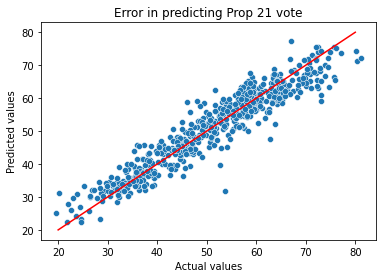

In [16]:
# your code here

### BEGIN SOLUTION
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set_xlabel('Actual values')
ax.set_ylabel('Predicted values')
ax.set_title('Error in predicting Prop 21 vote')
ax.plot([20,80],[20,80], color='r')  # add 45 degree line

### END SOLUTION


(9) Finally, plot the importance of each of the 3 predictor variables, in the same way as we did in class.

Comment briefly on your interpretation of the results.

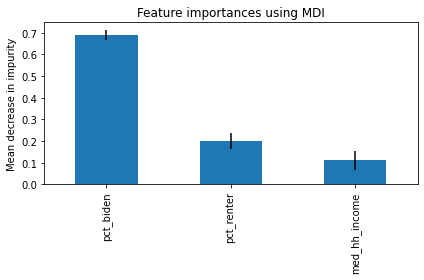

In [17]:
# your code here

### BEGIN SOLUTION
# more-or-less directly taken from the docs: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
### END SOLUTION

# Challenge Problem
Remember, you need to do at least two of these challenge problems this quarter.

This challenge problem is open ended for you to take in a direction that you are most interested in. Here are some suggestions:

* Extend the random forests model. To what extent can you improve the predictions by adding more variables and/or adjusting the hyperparameters? Use charts to show the change in mean absolute error.
* Use a neural network instead. How much does this improve the predictions? Use charts to compare the predictions to the random forests model.
* Examine the geographic distribution of the predictions, through mapping the errors. Where does your model perform best?

In all cases, write some brief interpretation in a markdown cell.